In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
x_train = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_x_train.txt')

x_test = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_x_test.txt')

y_train = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_y_train.txt')

y_test = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_y_test.txt')

x_val = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_x_val.txt')

y_val = np.loadtxt('/kaggle/input/ccs-training-data2/CCS_y_val.txt')

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN

In [5]:
# #model - GRU
# model2 = Sequential()
# model2.add(Embedding(output_dim = 50, input_dim = 21, input_length = 10))

# model2.add(GRU(128, return_sequences=True))
# model2.add(Dropout(0.2))

# model2.add(GRU(64)  )
# model2.add(Dropout(0.2))

# model2.add(Dense(1))

# model2.compile(loss='mean_squared_error', optimizer='adam')
# model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val))

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(output_dim=50 , input_dim=21, input_length=10))

model.add(tf.keras.layers.LSTM(128, return_sequences=False, input_shape=(10,21)))
model.add(tf.keras.layers.Dropout(0.5324275624952207))
model.add(tf.keras.layers.Dense(64))


model.add(tf.keras.layers.Dropout(0.08657063211846627))

model.add(tf.keras.layers.Dense(1))
optimizermodel = tf.keras.optimizers.Adam(0.001)
optimizermodel.learning_rate.assign(0.005)
model.compile(loss='mse', optimizer = optimizermodel,  metrics=['mse'])

hist = model.fit(x_train, y_train,
          batch_size=128,
          epochs= 200,
          verbose=2,
          validation_data=(x_val, y_val))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


259/259 - 6s - 22ms/step - loss: 8623.8223 - mse: 8623.8223 - val_loss: 627.0806 - val_mse: 627.0806
Epoch 2/200
259/259 - 1s - 5ms/step - loss: 1919.5627 - mse: 1919.5627 - val_loss: 702.7929 - val_mse: 702.7929
Epoch 3/200
259/259 - 1s - 4ms/step - loss: 1905.6200 - mse: 1905.6200 - val_loss: 629.1866 - val_mse: 629.1866
Epoch 4/200
259/259 - 1s - 5ms/step - loss: 1879.7094 - mse: 1879.7094 - val_loss: 645.5949 - val_mse: 645.5949
Epoch 5/200
259/259 - 1s - 4ms/step - loss: 1877.4036 - mse: 1877.4036 - val_loss: 649.6781 - val_mse: 649.6781
Epoch 6/200
259/259 - 1s - 5ms/step - loss: 1839.7118 - mse: 1839.7118 - val_loss: 623.8734 - val_mse: 623.8734
Epoch 7/200
259/259 - 1s - 4ms/step - loss: 1787.1401 - mse: 1787.1401 - val_loss: 670.4434 - val_mse: 670.4434
Epoch 8/200
259/259 - 1s - 5ms/step - loss: 1739.0906 - mse: 1739.0906 - val_loss: 623.3579 - val_mse: 623.3579
Epoch 9/200
259/259 - 1s - 4ms/step - loss: 1682.7557 - mse: 1682.7557 - val_loss: 660.4178 - val_mse: 660.4178
Epo

In [7]:
import lime
import lime.lime_tabular

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels as statsmodels
import statsmodels.stats.multitest as multitest
import scipy.stats as st
import pickle

In [8]:
%%time
amino_acids = ['A', 'C', 'D', 'E', 'End', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=x_train,
    mode='regression', 
    feature_names=[f'Pos{i+1}' for i in range(x_train.shape[1])],  # Features based on position
)
positions = [f'Pos{i}' for i in range(1, 11)]

# Initialize an array to store LIME contributions
num_positions = x_test.shape[1]  # Number of positions in the sequence
num_amino_acids = len(amino_acids)  # Number of amino acids
lime_contributions = [[[0.0] for _ in range(num_amino_acids)] for _ in range(num_positions)]

lime_values=[]
# Loop through each test instance
for i in range(len(x_test)):
    x_instance = x_test[i]
    ordered_contributions = {pos: 0.0 for pos in positions}

    # Generate LIME explanation for this instance
    exp = explainer.explain_instance(
        data_row=x_instance,
        predict_fn=model.predict
    )
    
    # Parse the LIME output and update contributions
    for feature_value, contribution in exp.as_list():
    # Extract position (e.g., 'Pos10' from 'Pos10 <= 4.00')
        pos = next((word for word in feature_value.split() if word.startswith('Pos')), None)
        if pos in ordered_contributions:
            ordered_contributions[pos] += contribution  # Add contribution (handles duplicates if needed)

    # Create an ordered list of contributions
    contributions_sorted = [ordered_contributions[pos] for pos in positions]
    # print(exp.as_list())
    # print(contributions_sorted)
    lime_values.append(contributions_sorted)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━

In [9]:


# Lưu lime_values vào file binary
with open('CCS_lime_values_LSTM.pkl', 'wb') as f:
    pickle.dump(lime_values, f)

In [10]:
# with open('/kaggle/input/lime-value/lime_values.pkl', 'rb') as f:
#     lime_values = pickle.load(f)

In [11]:
aa = []
i = 0

while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1


i = 0

while i < len(x_test):
    j=0

    while j < len(x_test[i]):
        aa[j][int(x_test[i][j])].append(lime_values[i][j])
        j+=1
    i+=1

In [12]:
# print(aa[0][0])

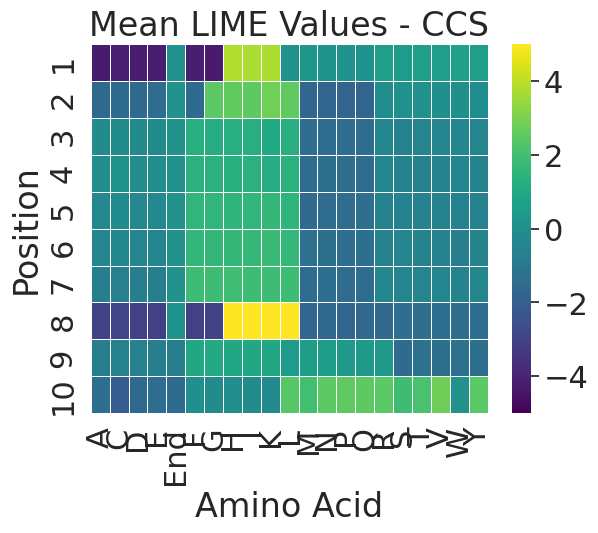

In [13]:
heatmap = []
i = 0
while i < len(aa):
    j=0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:

            #xóa số 0 ở đầu
            if len(aa[i][j])>1:
                aa[i][j] = aa[i][j][1:]
            #tính giá trị trung bình
            heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j]))))


        else:
            heatmap[i].append(0)

        j+=1
    i+=1
heatmap = np.array(heatmap)





plt.figure()
x_axis_labels = ['A','C','D','E','End','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8
ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis", vmin=-5, vmax=5)


ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean LIME Values - CCS')
ax.figure.savefig('CCS_LIME_LSTM.png')
ax.figure.savefig('CCS.svg')
plt.show()

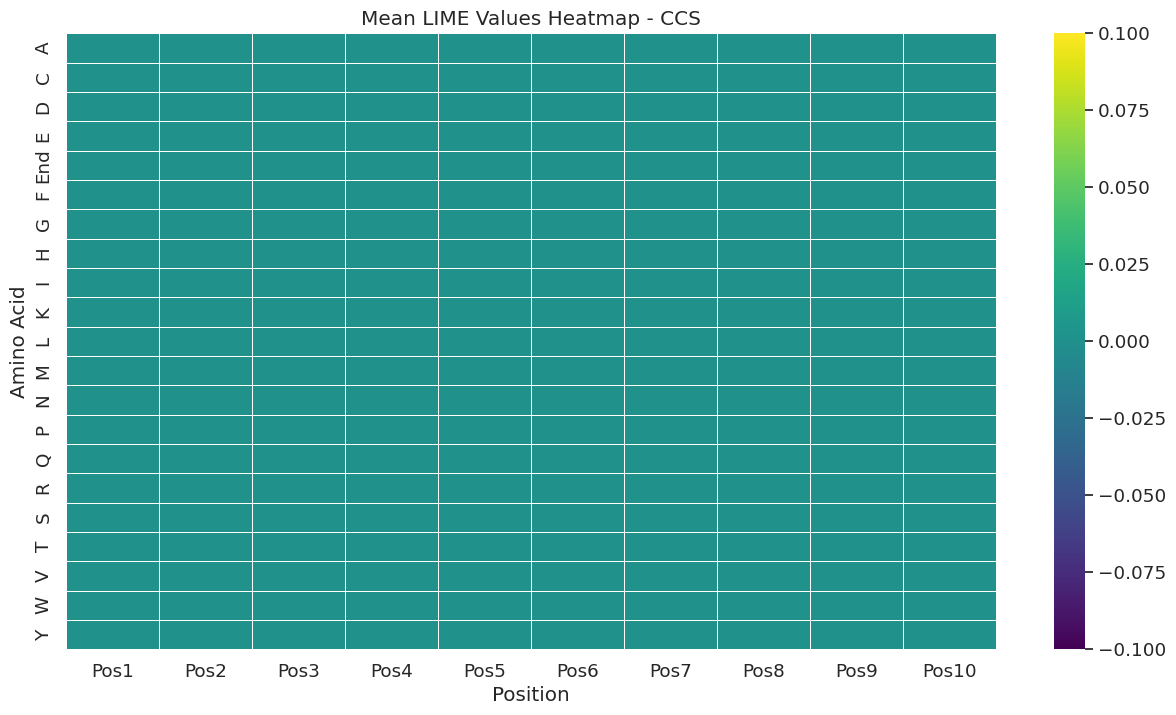

In [14]:
# Compute the average contribution for each amino acid at each position
heatmap = []
num_amino_acids = len(amino_acids)
lime_contributions = [[[0.0] for _ in range(num_amino_acids)] for _ in range(num_positions)]
for position in lime_contributions:
    row = []
    for aa_contributions in position:
        if len(aa_contributions) > 1:
            row.append(sum(aa_contributions[1:]) / len(aa_contributions[1:]))  # Exclude initial 0.0
        else:
            row.append(0.0)
    heatmap.append(row)

# Convert to a numpy array and transpose for heatmap compatibility
heatmap = np.array(heatmap).T

# Define axis labels
x_axis_labels = [f'Pos{i+1}' for i in range(num_positions)]  # Positions
y_axis_labels = amino_acids  # Amino acids

# Plot the heatmap using Seaborn
plt.figure(figsize=(15, 8))
sns.set(font_scale=1.2)

ax = sns.heatmap(
    heatmap,
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    cmap="viridis",
    linewidths=.5
)

ax.set_xlabel('Position')
ax.set_ylabel('Amino Acid')
ax.set_title('Mean LIME Values Heatmap - CCS')

plt.savefig('LIME_Heatmap.png')  # Save the heatmap as an image
plt.show()